# investigating motion of isopotential lines
Tim Tyree<br>
3.15.2023

In [1]:
from lib.my_initialization import *
from lib import *
from lib.measure.curvature import *
from scipy import ndimage
%load_ext autoreload
%autoreload 2

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [ ]:
#reset matplotlib settings
import matplotlib as mpl
# sns.reset_orig()
mpl.rc_file_defaults()

# define module

In [404]:
def unwind_contour(contour,width,height):
    """unwind_contour handles pbc
    
    Example Usage:
xy_values = unwind_contour(contour)
    """
    xy0 = contour[0]
    return np.array(unwrap_contour(x_values = contour[:,0],
                                y_values = contour[:,1], 
                                width=width, height=height)).T + np.array(xy0)

@njit
def pbc_robust_shift(xy1,xy2,width,height):
    """block unwrap one point xy1 to xy2 with 2x2 periodic boundary conditions (pbc).
    
    Example Usage:
xy_shift,mindist = pbc_robust_shift(xy1,xy2,width,height) 
    """
    xy1=com_curr
    xy2=com_next
    xy_shift=np.array((0,0))
    mindist = np.linalg.norm(xy1-xy2)
    ##the four sides
    tmp = np.array((width,0))
    dist=np.linalg.norm((xy1+tmp)-xy2)
    if dist<mindist:
        mindist=dist
        xy_shift = tmp
    tmp = np.array((-width,0))
    dist=np.linalg.norm((xy1+tmp)-xy2)
    if dist<mindist:
        mindist=dist
        xy_shift = tmp
    tmp = np.array((0,height))
    dist=np.linalg.norm((xy1+tmp)-xy2)
    if dist<mindist:
        mindist=dist
        xy_shift = tmp
    tmp = np.array((0,-height))
    dist=np.linalg.norm((xy1+tmp)-xy2)
    if dist<mindist:
        mindist=dist
        xy_shift = tmp
    ##the four corners
    tmp = np.array((-width,-height))
    dist=np.linalg.norm((xy1+tmp)-xy2)
    if dist<mindist:
        mindist=dist
        xy_shift = tmp
    tmp = np.array((-width,height))
    dist=np.linalg.norm((xy1+tmp)-xy2)
    if dist<mindist:
        mindist=dist
        xy_shift = tmp
    tmp = np.array((width,-height))
    dist=np.linalg.norm((xy1+tmp)-xy2)
    if dist<mindist:
        mindist=dist
        xy_shift = tmp
    tmp = np.array((width,height))
    dist=np.linalg.norm((xy1+tmp)-xy2)
    if dist<mindist:
        mindist=dist
        xy_shift = tmp
    return xy_shift,mindist

def comp_msdistance_to_spline(s,*args):
    pt_src,tck_dst = args
    pt_dst = splev(s, tck_dst)
    return np.sum((pt_src-pt_dst)**2)
#     return np.linalg.norm(pt_src-pt_dst)

In [615]:
#TODO: move to lib.model.ep.lr.utils
def bilinear_interpolate_state_lr(x_values,y_values,inVc,dVcdt,vx,vy,inmhjdfx):
    """
    Example Usage:
x_values = contour[:,0]
y_values = contour[:,1]
d_state = bilinear_interpolate_state_lr(x_values,y_values,inVc,dVcdt,vx,vy,inmhjdfx)
    """
    # bilinear_interpolate image to sites
    width,height=inVc.shape[:2]
    # states_txt = interpolate_img(x_values,y_values,width,height,txt)
    states_inVc = np.array(interpolate_img(x_values,y_values,width,height,inVc))
    states_dVcdt = np.array(interpolate_img(x_values,y_values,width,height,dVcdt))
    states_vx = np.array(interpolate_img(x_values,y_values,width,height,vx))
    states_vy = np.array(interpolate_img(x_values,y_values,width,height,vy))
    states_inmhjdfx = np.array(interpolate_img(x_values,y_values,width,height,inmhjdfx))
    d_state = pd.DataFrame(dict(X=x_values,Y=y_values,
                                  V=states_inVc[:,0],Ca=states_inVc[:,1],
                                  dVdt= states_dVcdt[:,0],dCadt= states_dVcdt[:,1],
                                  vX= states_vx,vY= states_vy,
                                  m= states_inmhjdfx[:,0],h= states_inmhjdfx[:,1],
                                  j= states_inmhjdfx[:,2],d= states_inmhjdfx[:,3],
                                  f= states_inmhjdfx[:,4],x= states_inmhjdfx[:,5],
                                 ))
    return d_state

def extract_curvilinear_states_lr(df_contours, contoursa, contoursa_next, vx, vy, inVc, dVcdt, inmhjdfx,
                                 s=1,per=1,upsampling_rate=4,**kwargs):
    """
    Example Usage:
df_state_curr,df_state_next = extract_curvilinear_states_lr(df_contours, contoursa, contoursa_next, vx, vy, inVc, dVcdt, inmhjdfx)#,s=1,per=1,**kwargs)
    """
    #input: df_contours, contoursa, contoursa_next, vx, vy, inVc, dVcdt, inmhjdfx
    #output: df_state_curr,df_state_next
    width,height = inVc.shape[:2]
    d_state_curr_lst=[]
    d_state_next_lst=[]
    #for each pair of contours
    for ci1,row in df_contours.iterrows():
        ci2= int(row['ci_next'])
        D0 = row['dist_next']
        contour1 = contoursa[ci1]
        contour2 = contoursa_next[ci2]

        #unwind_contour handles pbc
        xy_values1 = unwind_contour(contour1,width,height)
        xy_values2 = unwind_contour(contour2,width,height)
        #^this might be the hard-to-njit rate-limiting step in a faster contour epoch
        #compute cublic spline interpolant
        tck, s_values = splprep(xy_values1.T,s=s,per=per)
        tck_next, s_values_next = splprep(xy_values2.T,s=s,per=per)
        s_values_interpolated = np.linspace(0,1,int(np.ceil(s_values.shape[0]*upsampling_rate)))
        pts_curr = np.array(splev(s_values_interpolated, tck))
#         pts_next = np.array(splev(s_values_interpolated, tck_next))
        #compute current/next states along the contour respecting pbc
        d_state_curr = bilinear_interpolate_state_lr(pts_curr[0]%width,pts_curr[1]%height,inVc,dVcdt,vx,vy,inmhjdfx)
        d_state_curr['cid']=ci1


        #compute linearly interpolated contour positions and curvature
#         s_values_interpolated = np.linspace(0,1,int(np.ceil(s_values.shape[0]*upsampling_rate)))
#         pts_curr = np.array(splev(s_values_interpolated, tck))
        #measure the size and shape of either contour
        dxds = np.array(splev(s_values_interpolated, tck, der=1))
        dx2ds2 = np.array(splev(s_values_interpolated, tck, der=2))
        denom = np.linalg.norm(dxds,axis=0)**3
        wz_values = np.cross(dx2ds2,dxds,axis=0)
        # wz_values = np.cross(dxds,dx2ds2,axis=0)
        #Q: which of ^these has the "right" sign?
        #compute curvature
        curvature_values = wz_values / denom
        # curvature_values = np.abs(dx2ds2 * dyds - dxds * dy2ds2) / (dxds * dxds + dyds * dyds)**1.5
        d_state_curr['curvature'] = curvature_values


        #measure the size and shape of either contour
        s_values_interpolated = np.linspace(0,1,int(np.ceil(s_values_next.shape[0]*upsampling_rate)))
        pts_next = np.array(splev(s_values_interpolated, tck_next))
        d_state_next = bilinear_interpolate_state_lr(pts_next[0]%width,pts_next[1]%height,inVc,dVcdt,vx,vy,inmhjdfx)
        d_state_next['cid']=ci2
        dxds = np.array(splev(s_values_interpolated, tck_next, der=1))
        dx2ds2 = np.array(splev(s_values_interpolated, tck_next, der=2))
        denom = np.linalg.norm(dxds,axis=0)**3
        wz_values = np.cross(dx2ds2,dxds,axis=0)
        #compute curvature
        curvature_values = wz_values / denom    
        # curvature_values = np.abs(dx2ds2 * dyds - dxds * dy2ds2) / (dxds * dxds + dyds * dyds)**1.5
        d_state_next['curvature'] = curvature_values
        #record
        d_state_curr_lst.append(d_state_curr)
        d_state_next_lst.append(d_state_next)
    df_state_curr = pd.concat(d_state_curr_lst)
    df_state_next = pd.concat(d_state_next_lst)
    return df_state_curr,df_state_next


In [621]:
def extract_local_reference_frame(df_contours, contoursa, contoursa_next, width, height,
                                 s=1,per=1,upsampling_rate=4,**kwargs):
    """
    Example Usage:
dict_contour_pairs = extract_local_reference_frame(df_contours, contoursa, contoursa_next, width, height)#,s=1,per=1,upsampling_rate=4,**kwargs)
    """
    #for each pair of contours
    dict_contour_pairs=dict()
    for ci1,row in df_contours.iterrows():
        ci2= int(row['ci_next'])
        D0 = row['dist_next']
        contour1 = contoursa[ci1]
        contour2 = contoursa_next[ci2]
        #unwind_contour handles pbc
        xy_values1 = unwind_contour(contour1,width,height)
        xy_values2 = unwind_contour(contour2,width,height)
        #^this might be the hard-to-njit rate-limiting step in a faster contour epoch
        #compute cublic spline interpolant
        tck, s_values = splprep(xy_values1.T,s=s,per=per)
        tck_next, s_values_next = splprep(xy_values2.T,s=s,per=per)
        s_values_interpolated = np.linspace(0,1,int(np.ceil(s_values.shape[0]*upsampling_rate)))
        pts_curr = np.array(splev(s_values_interpolated, tck))
        s_values_interpolated = np.linspace(0,1,int(np.ceil(s_values_next.shape[0]*upsampling_rate)))
        pts_next = np.array(splev(s_values_interpolated, tck_next))
        #compute center of mass
        com_curr = np.mean(pts_curr,axis=1)
        com_next = np.mean(pts_next,axis=1)
        #block unwrap pts_src from pts_dst
        xy_shift_unwrap,mindist_unwrap = pbc_robust_shift(com_curr,com_next,width,height) 
        com_curr_unwrap = (com_curr + xy_shift_unwrap)
        displacement = com_next - com_curr_unwrap
        #center frames
        pts_in = (pts_curr.T+xy_shift_unwrap).T
        pts_out = pts_next
        xy_shift = com_next - com_curr #+ xy_shift_unwrap)
        #record contour information as a learning task
        dict_contour_pairs[ci1]=dict(
            pts_in=pts_in,
            pts_out=pts_out,
            tck_in=tck,
            tck_out=tck_next,
            displacement=displacement,
            contour1=contour1,
            contour2=contour2,
            xy_shift=xy_shift,
            xy_shift_unwrap=xy_shift_unwrap,
            ci2=ci2,
        )
    return dict_contour_pairs

In [601]:
# d_state = bilinear_interpolate_state_lr(x_values,y_values,inVc,dVcdt,vx,vy,inmhjdfx)
# inVc.shape

# GOAL: investigate whether there are repeatable forces acting along activation fronts

# DONE: generate two sets of contours from which to dev 

In [2]:
#DONE: import example and compute arclen_values
#DONE: interpolate txt to contour nodes
#DONE: get a sample activation front identified in terms of arcVc_values
#DONE: plot curvature versus sigma
# - __TODO__: save an activation front curvature values versus time as .csv
#TODO: see how ^that evolves with time
#TODO(and then...): use ^this method to compute apparent forces from a time series of positions
# - ...TODO: come up with some simple rules for curvature versus time
# - ...TODO: use intersections to compute interactions between activation fronts

Method for smooth numerical curvature
1. fitting a BSpline through the data points and 
1. computing the curvature as a function of derivatives of ^that BSpline fit.

In [540]:
# 1

In [510]:
# #load a mesh from Luo-Rudy
# ic_fn=search_for_file()
try:
    ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-out/ic008.33.npz"
    txt=load_buffer(ic_fn)
    t=0
except FileNotFoundError as e:
    ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-in/ic008.33.npz"
    txt=load_buffer(ic_fn)
    t=0   
    
save_folder=f"{nb_dir}/Figures/mov"    
DX=0.025
width=txt.shape[0]
L = width*DX #cm
# ds=5.
frameno=0
save_every_n_frames=50
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]
# V_threshold=-50;
# V_threshold=-40;
V_threshold=-30;

dt=0.01
dt=0.1
# dt=0.5 #unstable

# DT=2. #22s
# DT=4.  #44s?
# DT=4.  #44s?
DT=100.  #44s?
nsteps_per_DT=int(DT/dt)

# comp_dict_topo_full_color=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=0.)
# get_one_step at this dt
__, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,dt=dt,width=width,height=height,ds=L,
    diffCoef=0.001,
    #diffCoef=0.0005,
    Cm=1.0)


In [511]:
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)
# txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
img_prev=txt[...,0].copy()
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
for n in range(nsteps_per_DT):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    #t+=dt
t+=DT
# txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
img=inVc[...,0]
dimgdt=dVcdt[...,0]

In [512]:
levela=-30
levelb=0

In [513]:
imga=img.copy()
imgb=dimgdt.copy()
#get all xy coordinates of level sets:
#HINT: find_contours
contoursa = find_contours(array=imga,level=levela,
    fully_connected='low',positive_orientation='low',mode='pbc')
contoursb = find_contours(array=imgb,level=levelb,
    fully_connected='low',positive_orientation='low',mode='pbc')

num_contoursa = len(contoursa)
num_contoursb = len(contoursa)
print(f"{num_contoursa=}, {num_contoursb=}")

num_contoursa=5, num_contoursb=5


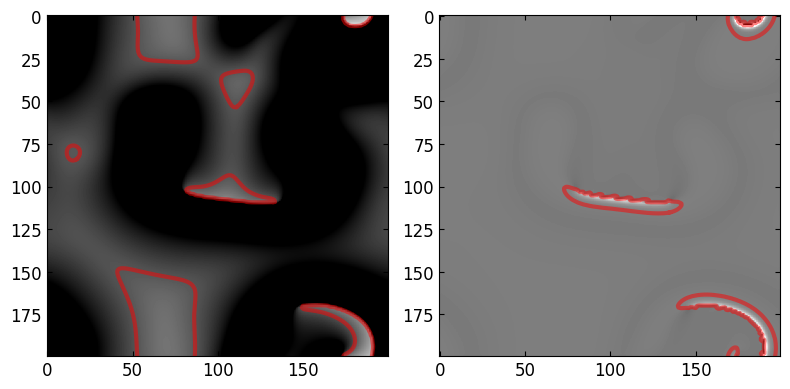

In [514]:
cmap='gray'
fontsize=12
figsize=(12,6)
figsize=(8,4)
extent=(-L/2,L/2,-L/2,L/2)
fig,axs=plt.subplots(ncols=2,figsize=figsize)
ax=axs[0]
ax.imshow(imga,cmap=cmap,vmin=-50,vmax=10)#,extent=extent)
#TODO: overlay level sets for contoursa,b
plot_contours_pbc(contoursa, ax, linewidth=3, min_num_vertices=6, linestyle='-', alpha=0.5, color='red')#'blue')

ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,fontsize=fontsize,xlabel='',ylabel='')
ax=axs[1]
ax.imshow(imgb,cmap=cmap,vmin=-30,vmax=30)#,extent=extent)
#TODO: overlay level sets for contoursa,b
plot_contours_pbc(contoursb, ax, linewidth=3, min_num_vertices=6, linestyle='-', alpha=0.5, color='red')#'blue')

ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,fontsize=fontsize,xlabel='',ylabel='')
# plt.xticks(rotation=0)#, ha='right')
plt.tight_layout()
plt.show()

In [515]:
# DT=2. #22s
# DT=4.  #44s?
# DT=4.  #44s?
DT=10.  #44s?
nsteps_per_DT=int(DT/dt)

# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)
# txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
img_prev=txt[...,0].copy()
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
inVc_curr,outVc_curr,inmhjdfx_curr,outmhjdfx_curr,dVcdt_curr = inVc.copy(),outVc.copy(),inmhjdfx.copy(),outmhjdfx.copy(),dVcdt.copy()
for n in range(nsteps_per_DT):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    #t+=dt
t+=DT
# txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
img=inVc[...,0]
dimgdt=dVcdt[...,0]

In [516]:
imga_next=img.copy()
imgb_next=dimgdt.copy()
inVc_next,outVc_next,inmhjdfx_next,outmhjdfx_next,dVcdt_next = inVc.copy(),outVc.copy(),inmhjdfx.copy(),outmhjdfx.copy(),dVcdt.copy()
#get all xy coordinates of level sets:
#HINT: find_contours
contoursa_next = find_contours(array=imga_next,level=levela,
    fully_connected='low',positive_orientation='low',mode='pbc')
contoursb_next = find_contours(array=imgb_next,level=levelb,
    fully_connected='low',positive_orientation='low',mode='pbc')

num_contoursa = len(contoursa)
num_contoursb = len(contoursa)
print(f"{num_contoursa=}, {num_contoursb=}")

num_contoursa=5, num_contoursb=5


In [517]:
# HYPOTHESIS: bosonic holes can account for the attractive force between spiral tips as they annihilate

In [518]:
compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)

In [519]:
#measure system
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
img=inVc[...,0]#.astype(np.float32)
dimgdt=dVcdt[...,0]#.astype(np.float32)
# dict_out=compute_all_spiral_tips(t,img,img+dt*dimgdt,level1=V_threshold,level2=V_threshold)#,width=width,height=height)
# # t: t=4.000, num tips: 12
dict_out=compute_all_spiral_tips(t,img,img+dt*dimgdt,level1=V_threshold,level2=V_threshold)#,width=width,height=height)
# t: t=4.000, num tips: 6
dict_out['n']=len(dict_out['x'])
n = dict_out['n']
#print_dict(dict_out)
print(f"t: {t=:.3f}, num tips: {dict_out['n']}")

t: t=110.000, num tips: 4


# compute smoothed splines of contour pairs

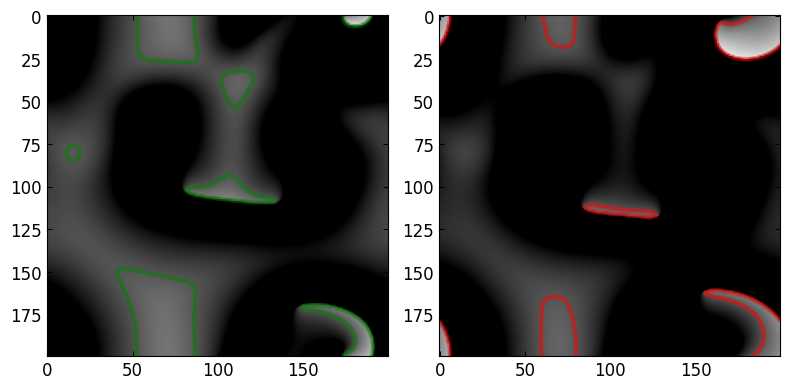

In [520]:
cmap='gray'
fontsize=12
figsize=(12,6)
figsize=(8,4)
fig,axs=plt.subplots(ncols=2,figsize=figsize)
ax=axs[0]
ax.imshow(imga,cmap=cmap,vmin=-50,vmax=10)#,extent=extent)
plot_contours_pbc(contoursa, ax, linewidth=3, min_num_vertices=6, linestyle='-', alpha=0.5, color='green')#'blue')
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,fontsize=fontsize,xlabel='',ylabel='')
ax=axs[1]
ax.imshow(imga_next,cmap=cmap,vmin=-50,vmax=10)#,extent=extent)
plot_contours_pbc(contoursa_next, ax, linewidth=3, min_num_vertices=6, linestyle='-', alpha=0.5, color='red')#'blue')
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,fontsize=fontsize,xlabel='',ylabel='')
plt.tight_layout()
plt.show()

In [521]:
#compute discrete -grad(dVdt) vector field
# imgb=dimgdt
# imgb_next=dimgdt
ddVdtdx=np.gradient(imgb,axis=0)/DX #not stable in time
ddVdtdy=-np.gradient(imgb,axis=1)/DX #not stable in time
vx=ddVdtdx
vy=ddVdtdy
ddVdtdx=np.gradient(imgb_next,axis=0)/DX #not stable in time
ddVdtdy=-np.gradient(imgb_next,axis=1)/DX #not stable in time
vx_next=ddVdtdx
vy_next=ddVdtdy

In [523]:
# dict2d = dict(inVc=inVc,dVcdt=dVcdt,vx=vx,vy=vy,inmhjdfx=inmhjdfx)
dict2d_curr = dict(inVc=inVc_curr,dVcdt=dVcdt_curr,vx=vx,vy=vx,inmhjdfx=inmhjdfx_curr)
dict2d_next = dict(inVc=inVc_next,dVcdt=dVcdt_next,vx=vx_next,vy=vy_next,inmhjdfx=inmhjdfx_next)

In [476]:
d_state_lst=[]
for i,contour in enumerate(contoursa):
    #contour nodes are chosen on the edges between sites
    x_values = contour[:,0]
    y_values = contour[:,1]
    # bilinear_interpolate image to sites
    # states_txt = interpolate_img(x_values,y_values,width,height,txt)
    states_inVc = np.array(interpolate_img(x_values,y_values,width,height,inVc))
    states_dVcdt = np.array(interpolate_img(x_values,y_values,width,height,dVcdt))
    states_vx = np.array(interpolate_img(x_values,y_values,width,height,vx))
    states_vy = np.array(interpolate_img(x_values,y_values,width,height,vy))
    states_inmhjdfx = np.array(interpolate_img(x_values,y_values,width,height,inmhjdfx))
    d_state = pd.DataFrame(dict(X=x_values,Y=y_values,
                                  V=states_inVc[:,0],Ca=states_inVc[:,1],
                                  dVdt= states_dVcdt[:,0],dCadt= states_dVcdt[:,1],
                                  vX= states_vx,vY= states_vy,
                                  m= states_inmhjdfx[:,0],h= states_inmhjdfx[:,1],
                                  j= states_inmhjdfx[:,2],d= states_inmhjdfx[:,3],
                                  f= states_inmhjdfx[:,4],x= states_inmhjdfx[:,5],
                                 ))
    d_state['cid']=i
    d_state_lst.append(d_state)
df_state = pd.concat(d_state_lst)
df_state.shape

(683, 15)

In [477]:
df_state.head()

,X,Y,V,Ca,dVdt,dCadt,vX,vY,m,h,j,d,f,x,cid
0,0.0,86.422398,-42.969374,0.000003,-0.610025,-5.950258e-08,-0.121601,0.161856,0.499787,0.001184,0.000726,0.291142,0.861908,0.157383,0
1,1.0,86.361301,-42.141025,0.000003,-0.603120,-5.710281e-08,-0.123609,-0.240408,0.528054,0.000868,0.000546,0.298359,0.860178,0.157745,0
2,2.0,86.314572,-41.340880,0.000003,-0.580022,-5.467750e-08,-0.123705,-0.494770,0.555020,0.000575,0.000401,0.305587,0.858799,0.157920,0
3,3.0,86.282405,-40.568537,0.000003,-0.558996,-5.221674e-08,-0.125553,-0.459658,0.580630,0.000268,0.000282,0.312855,0.857722,0.157905,0
4,4.0,86.264864,-39.825674,0.000003,-0.540001,-4.969526e-08,-0.128116,-0.426351,0.604753,0.000022,0.000208,0.320190,0.856939,0.157722,0


# TODO: use the Chamfer distance to find contour pairs between the two frames

$D_{ij}^{(Chamfer)} = \sum_{x_i \in x}{\min_{y_j \in y}{||x_i-y_j||^2}} + \sum_{y_j \in y}{\min_{x_i \in x}{||x_i-y_j||^2}}$

Denote the mean curvature of contour i=x as $\bar H(X_i)$ with mean stiffness $\bar\lambda_i = \lambda(k_i(t))$.

Denote the mean tension as $\bar\tau_i$ for the $i^{th}$ contour with arclength, $L_i=(\Phi_{\Delta t}(X_i))$

$Loss = \sum_{ij\in P_{airs}} D_{ij}^{(Chamfer)} + \sum_{i}\bar\lambda_i H(\Phi_{\Delta t}(X_i)) - \sum_{i}\bar\tau_i L_i$

In [526]:
num1 = len(contoursa)
num2 = len(contoursa_next)
maxdist=width*height
ci2_neighbor_lst=[]
dist_lst=[]
for ci1 in range(num1):
    dist=maxdist
    for ci2 in range(num2):
        dist_chamfer = chamfer_distance(contoursa[ci1], contoursa_next[ci2], metric='l2', direction='bi')
        if dist_chamfer<dist:
            dist=dist_chamfer
            ci2_neighbor = ci2
    #record
    ci2_neighbor_lst.append(ci2_neighbor)
    dist_lst.append(dist)
df_contours = pd.DataFrame(dict(
    ci_next=ci2_neighbor_lst,
    dist_next=dist_lst
))
# df_contours

#filter any contours that disappear
df_contours = df_contours.sort_values(by='dist_next').groupby(by='ci_next').head(1)
print(f"{num1=}, {num2=}")

num1=5, num2=3


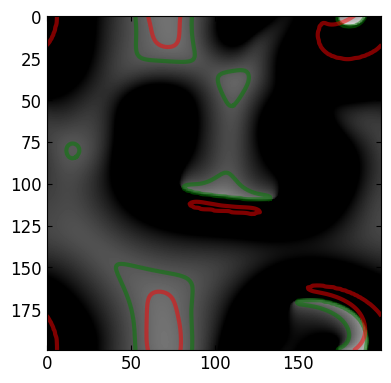

In [527]:
#visualize the pairings
cmap='gray'
fontsize=12
figsize=(12,6)
figsize=(4,4)
fig,ax=plt.subplots(figsize=figsize)
# ax=axs[0]
ax.imshow(imga,cmap=cmap,vmin=-50,vmax=10)#,extent=extent)
# ax.imshow(imga_next,cmap=cmap,vmin=-50,vmax=10)#,extent=extent)
plot_contours_pbc(contoursa, ax, linewidth=3, min_num_vertices=6, linestyle='-', alpha=0.5, color='green')#'blue')
plot_contours_pbc(contoursa_next, ax, linewidth=3, min_num_vertices=6, linestyle='-', alpha=0.5, color='red')#'blue')
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,fontsize=fontsize,xlabel='',ylabel='')
plt.tight_layout()
plt.show()

In [528]:
# # plot_contours_pbc(contoursa, plt.gca(), linewidth=3, min_num_vertices=6, linestyle='-', alpha=0.5, color='green')#'blue')
# plot_contours_pbc([contoursa[0]], plt.gca(), linewidth=3, min_num_vertices=6, linestyle='-', alpha=0.5, color='green')#'blue')


In [529]:
len(contoursa)

5

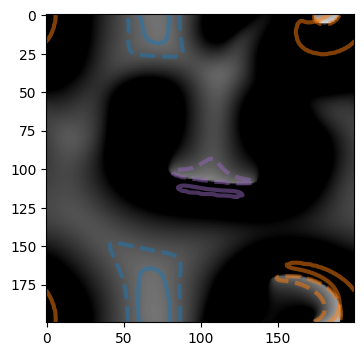

In [606]:
#visualize the pairings
cmap='gray'
fontsize=12
figsize=(12,6)
figsize=(4,4)
fig,ax=plt.subplots(figsize=figsize)
# ax=axs[0]
ax.imshow(imga,cmap=cmap,vmin=-50,vmax=10)#,extent=extent)
# ax.imshow(imga_next,cmap=cmap,vmin=-50,vmax=10)#,extent=extent)
# #for each pair of contours
for ci1,row in df_contours.iterrows():
    ci2= int(row['ci_next'])
    D0 = row['dist_next']
    contour1 = contoursa[ci1]
    contour2 = contoursa_next[ci2]
    plot_contours_pbc([contour1], ax=ax, linewidth=3, min_num_vertices=6, linestyle='--', alpha=0.5, color=f'C{ci1}')#'blue')
    plot_contours_pbc([contour2], ax=ax, linewidth=3, min_num_vertices=6, linestyle='-', alpha=0.5, color=f'C{ci1}')#'blue')
#     plot_contours_pbc([contour1[0]], ax=ax, linewidth=3, min_num_vertices=6, linestyle='-', alpha=0.5, color=f'C{ci1}')#'blue')
#     plot_contours_pbc([contour2[0]], ax=ax, linewidth=3, min_num_vertices=6, linestyle=':', alpha=0.5, color=f'C{ci1}')#'blue')
# ax.tick_params(top=True, right=True,direction='in',which='both')
# format_plot(ax=ax,fontsize=fontsize,xlabel='',ylabel='')
# plt.tight_layout()
plt.show()

In [607]:
for ci1,row in df_contours.iterrows():
    ci2= int(row['ci_next'])
    D0 = row['dist_next']
    

In [608]:
#heretimheretim
#TODO: verify the curves are paired correctly
#TODO: develop a simple way to map pairs of curve onto one another


# compute spline interpolants of either contour

In [617]:
upsampling_rate=4
per=1 #use periodic boundary conditions
s=1 #enough smoothing to remove the subpixel wiggles
# s=0 #no smoothing
# s=5 #too much smoothing
dict_contour_pairs = extract_local_reference_frame(df_contours, contoursa, contoursa_next, width, height)#,s=1,per=1,upsampling_rate=4,**kwargs)
df_state_curr,df_state_next = extract_curvilinear_states_lr(df_contours, contoursa, contoursa_next, vx, vy, inVc, dVcdt, inmhjdfx)#,s=1,per=1,**kwargs)

In [618]:
dict_mean_states=dict()
#for each pair of contours
for ci1,row in df_contours.iterrows():
    ci2= int(row['ci_next'])
    D0 = row['dist_next'] 
    contour1 = contoursa[ci1]
    contour2 = contoursa_next[ci2]
    #unwind_contour handles pbc
    xy_values1 = unwind_contour(contour1,width,height)
    xy_values2 = unwind_contour(contour2,width,height)
    #^this might be the hard-to-njit rate-limiting step in a faster contour epoch
    #compute cublic spline interpolant
    tck, s_values = splprep(xy_values1.T,s=s,per=per)
    tck_next, s_values_next = splprep(xy_values2.T,s=s,per=per)
    s_values_interpolated = np.linspace(0,1,int(np.ceil(s_values.shape[0]*upsampling_rate)))
    pts_curr = np.array(splev(s_values_interpolated, tck))
    pts_next = np.array(splev(s_values_interpolated, tck_next))
    #compute linearly interpolated contour positions and curvature
    #measure the size and shape of either contour
    dxds = np.array(splev(s_values_interpolated, tck, der=1))
    dx2ds2 = np.array(splev(s_values_interpolated, tck, der=2))
    denom = np.linalg.norm(dxds,axis=0)**3
    wz_values = np.cross(dx2ds2,dxds,axis=0)
    # wz_values = np.cross(dxds,dx2ds2,axis=0)
    #Q: which of ^these has the "right" sign?
    curvature_values = wz_values / denom
    # curvature_values = np.abs(dx2ds2 * dyds - dxds * dy2ds2) / (dxds * dxds + dyds * dyds)**1.5
    # return curvature_values,new_points,dxds,dx2ds2
    # new_points,curvature_values,dxds,dx2ds2 = comp_contour_curvature(contour)
    #compute the average curvature measures
    H0 = np.mean(curvature_values)    
    rhomax = np.max(curvature_values)/2
    rhomin = np.min(curvature_values)/2
    #compute the overall length
    arclen = np.linalg.norm(np.diff(new_points),axis=0).sum()
    #record
    df_contours.loc[ci1,'mncurv']=H0
    df_contours.loc[ci1,'arclen']=arclen
    df_contours.loc[ci1,'rhomin']=rhomin
    df_contours.loc[ci1,'rhomax']=rhomax
    #get the interpolated values
    dict_mean_state_curr = df_state_curr.loc[df_state_curr['cid']==ci1].mean().to_dict()
    dict_mean_state_next = df_state_next.loc[df_state_next['cid']==ci2].mean().to_dict()
    #record
    dict_mean_states[ci1] = dict(dict_mean_state_curr=dict_mean_state_curr,
                             dict_mean_state_next=dict_mean_state_next)
    df_contours.loc[ci1,'V_curr']=dict_mean_state_curr['V']
    df_contours.loc[ci1,'dVdt_curr']=dict_mean_state_curr['dVdt']
    df_contours.loc[ci1,'V_next']=dict_mean_state_next['V']
    df_contours.loc[ci1,'dVdt_next']=dict_mean_state_next['dVdt']
df_contours

,ci_next,dist_next,mncurv,arclen,rhomin,rhomax,V_curr,V_next,dVdt_curr,dVdt_next
4,2,16.930733,0.060595,134.966477,-0.036749,1.914566,-50.089583,-48.334993,-0.098031,-0.287552
0,1,21.091253,0.029091,134.966477,-0.014000,0.300130,-63.554045,-54.581845,-0.647319,-0.800896
1,0,41.462801,0.052487,134.966477,-0.067075,0.653655,-46.084489,-51.082076,0.792103,0.068916


In [619]:
df_contours,
df_state_curr,
df_state_next,
dict_contour_pairs,
dict_mean_state_curr,
dict_mean_state_next

{'X': 151.04676011289752,
 'Y': 174.26726081850143,
 'V': -46.08448863713151,
 'Ca': 2.0223065553296104e-06,
 'dVdt': 0.7921033117597791,
 'dCadt': -7.690964383458799e-08,
 'vX': 5.769530793705951,
 'vY': 2.493091309052609,
 'm': 0.5139359900938061,
 'h': 0.19708196249877924,
 'j': 0.13211998795310745,
 'd': 0.09559203583788968,
 'f': 0.9014921028057569,
 'x': 0.15470744143000706,
 'cid': 1.0,
 'curvature': 0.0524871273985702}

In [620]:
dict_mean_state_next

{'X': 108.76094741827498,
 'Y': 147.41015781083635,
 'V': -51.08207582636475,
 'Ca': 2.2021953889069606e-06,
 'dVdt': 0.06891608439075446,
 'dCadt': -7.70028786225039e-08,
 'vX': -2.1852386049155403,
 'vY': -1.2106401035134573,
 'm': 0.36292327705975114,
 'h': 0.14610931893873358,
 'j': 0.10205152945388933,
 'd': 0.11192526424637726,
 'f': 0.9009140193510914,
 'x': 0.15533981082392995,
 'cid': 0.0,
 'curvature': 0.030106728858458096}

In [625]:
# np.linalg.norm(dxds,axis=1)
# new_points[:,0],new_points[:,-1]
data = dict(t=t,
            model='Luo-Rudy',
            dict_tips=dict_out,
            ic_fn=ic_fn,
            df_contours=df_contours,
            dict_contour_pairs=dict_contour_pairs,
            df_state_curr=df_state_curr,
            df_state_next=df_state_next,
            dict_mean_state_curr=dict_mean_state_curr,
            dict_mean_state_next=dict_mean_state_next,
    dict1d = dict(contoursa=contoursa,
                    contoursa_next=contoursa_next,
                    contoursb=contoursb,
                    contoursb_next=contoursb_next,
                    levela=levela,levelb=levelb),
    dict2d = dict(img=imga,
            img_next=imga_next,
            current_fields = dict2d_curr,
            next_fields = dict2d_next),
)
data.keys()

dict_keys(['t', 'model', 'dict_tips', 'ic_fn', 'df_contours', 'dict_contour_pairs', 'df_state_curr', 'df_state_next', 'dict_mean_state_curr', 'dict_mean_state_next', 'dict1d', 'dict2d'])

In [645]:
#save the data
data_folder = '/'.join(ic_fn.split('/')[:-2])+'/contour_data'
if not os.path.exists(data_folder):
    os.mkdir(data_folder)
data_fn = ic_fn.split('/')[-1].replace('.npz',f'_contours_t_{int(t)}.pkl')#.replace('ic','contours')
data_dir = os.path.join(data_folder,data_fn)
save_to_pickle(data_dir,data)
print(f"{data_dir=}")

data_dir='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/contour_data/ic008.33_contours_t_110.pkl'


In [647]:
# !open /Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/contour_data

In [353]:
#input: a learning task (xy before/after)
#output: minimum chanfer distance contour deformation
#HINT: i think pytorch3d has a function optimized for this

In [354]:
# Q: can i reduce it to slerp interpolating two curves in 2D (embedded in 3D)?
# A: yes AFTER I find a closest point on the target mesh.  
#  ^ this requires preprocessing with some kind of chanfer solve

In [495]:
print(f"{com_curr=},\n{com_next=}")

com_curr=array([-15.91230421, 174.26726082]),
com_next=array([191.23985873, 182.29096457])


In [496]:
#xy_shift_unwrap is the shift from periodic bc's only!
#block unwrap pts_src from pts_dst
xy_shift_unwrap,mindist_unwrap = pbc_robust_shift(com_curr,com_next,width,height) 
com_curr_unwrap = (com_curr + xy_shift_unwrap)
#compute xy_shift to center the two shapes
# xy_shift = com_curr_unwrap - com_next
displacement = com_next - com_curr_unwrap
# print(f"{com_curr=},\n{com_curr+xy_shift=},\n{com_next=}")
# print(f"{xy_shift=},\n{xy_shift_unwrap=}")
# print(f"{com_curr+xy_shift_unwrap=},\n{com_next=}\n{displacement=}")
print(f"{com_next - (com_curr+xy_shift_unwrap) =}\n{displacement=}")
#they agree, it seems

com_next - (com_curr+xy_shift_unwrap) =array([7.15216294, 8.02370375])
displacement=array([7.15216294, 8.02370375])


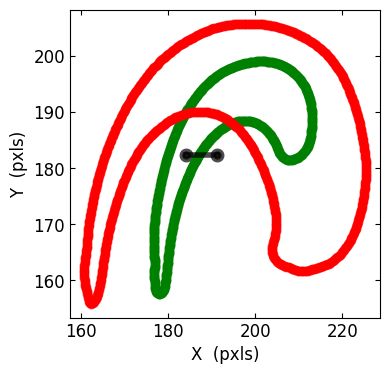

In [498]:
fig,ax=plt.subplots(figsize=figsize)
# plt.quiver([com_curr_unwrap[0]],[com_curr_unwrap[1]],[displacement[0]],[displacement[1]],
#         lw=4,color='k',alpha=0.7,units='xy')
ax.scatter([com_curr_unwrap[0],com_curr_unwrap[0]+displacement[0]],
            [com_curr_unwrap[1],com_curr_unwrap[1]]+displacement[1],
        lw=4,color='k',alpha=0.7)#,units='xy')
ax.plot([com_curr_unwrap[0],com_curr_unwrap[0]+displacement[0]],
            [com_curr_unwrap[1],com_curr_unwrap[1]]+displacement[1],
        lw=4,color='k',alpha=0.7)#,units='xy')
ax.scatter(x=pts_curr[0]+xy_shift[0],y=pts_curr[1]+xy_shift[1],color='g',alpha=0.7)
ax.scatter(x=pts_next[0],y=pts_next[1],color='r',alpha=0.7)
format_plot(ax=ax,fontsize=fontsize,xlabel='X  (pxls)',ylabel='Y  (pxls)')
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.show()

# TODO: caste this into a point cloud deformation problem and then try to solve it efficiently in pytorch3d

In [622]:
# import os
# import torch
# # from pytorch3d.io import load_obj, save_obj

# don't expect good results getting the minimal displacements with simulated annealing

In [507]:
# seed=42
# # scipy.optimize.minimize(mindist, )
# #TODO: recall latest dual simulated annealing solver
# #TODO: cp it here
# #TOOD: modify it to find the s that minimizes the distance between pt0_src and pts_dst
# pts_src = xy_values1 + xy_shift
# tck_dst = tck_next
# for pt0_src in pts_src:
#     args = (pt0_src,tck_dst)
#     bounds = [(-0.01,1.01),]
# res = dual_annealing(
#     comp_distance_to_spline,
#     bounds=bounds,
#     args=args,
#     maxiter=10000,
# #     local_search_options={},
# #     initial_temp=5.0,
# #     initial_temp=5230.0,
# #     restart_temp_ratio=2e-05,
# #     visit=2.62,
# #     accept=-5.0,
# #     maxfun=10000000.0,
# #     seed=seed,
#     no_local_search=True,
# #     callback=None,
# #     x0=None,
# )

In [506]:
# print(f"{s}: {comp_distance_to_spline(s,*args)=}")
# print(f"{res.x[0]}: {comp_distance_to_spline(res.x,*args)=}")

In [505]:
# xv = np.linspace(-0.1,1.1,100)
# yv = np.array([comp_msdistance_to_spline(x,*args) for x in xv])
# plt.plot(xv,yv)

In [504]:
# dual_annealing?

In [499]:
# # curvature_values = np.abs(dx2ds2 * dyds - dxds * dy2ds2) / (dxds * dxds + dyds * dyds)**1.5
# # return curvature_values
# plt.plot(xy_values[:,0],xy_values[:,1])#,c=curvature_values,cmap='gray_r')
# plt.plot(new_points[0],new_points[1])#,c=curvature_values,cmap='gray_r')
# plt.scatter(x=new_points[0],y=new_points[1],c=curvature_values,cmap='gray_r')
# # new_points.shape
# # TODO(later): determine the maximum curvature location

In [503]:
#potential first integrals:
#mean curvature (a topological invariant here?)
#tensile energy (requires notion of mass)

In [35]:
dist_chamfer

145.865550846833

In [20]:
#TODO: place -grad(dVdt) quiver at each node of contoursa


In [21]:
#fastest way to do this:
#general bilinear interpolation on the square
#provably exact using only 3 pixels
#HINT: search bilinear from before

In [23]:
# DONE: map these guys to pandas.DataFrame 
# inVc,dVcdt,inmhjdfx,vx,vy,x,y,cid

In [25]:
# np.floor(contour[0])

In [26]:
#DONE(later): smooth dimgdt slightly and detect contours on its bumpy surface
#DONE: overlay contoursa
#TODO: estimate the time-like tangent space of contoursa along the curve
#TODO: visualize the dual states with a quiver plot
#TODO: dev function that smoothly interpolates nodes from initial dual state to final dual state 
#HINT: what function smoothly interpolates from step to step+1 that
#  1. minimizes the distance between each node and the interpolated curve at step+1
#  2. minimizes the change in distance between two nodes
#HINT: as DT-->0, contoursa must move in the direction of -grad(dVdt)
#HYPOTHESIS: the local texture properties govern the instantaneous change in curvature of activation fronts
#CLAIM: if we can predict the time evolution of the kymograph of local properties, 
#    then we can predict the direction of -grad(dVdt)


In [27]:
#GOAL: estimate spiral tip locations using only the local properties of contoursa

In [28]:
# ax.quiver(x, y, z, us, vs, ws, length=1, normalize=False, color='orange', label='spring forces')

In [34]:
# xy_values

In [32]:
#TODO: estimate the space-like tangent space of contoursa along the curve
xy_values = contour
new_points=comp_interpolated_points(xy_values,s=1)
curvature_values=comp_curvature(xy_values)/DX
sigma_unitless_values=np.linspace(0,1,curvature_values.shape[0])
sigma_values=arclen*sigma_unitless_values
c_values=curvature_values

ValueError: Invalid inputs.

In [ ]:
# Q: does comp_curvature respect pbc?
comp_curvature

In [ ]:
# TODO(later): determine the maximum curvature location
